In [1]:
import tensorflow as tf
import autokeras as ak

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

### Load MNIST dataset

In [3]:
import numpy as np

num_instances = 1000

# Generate image data.
image_data = np.random.rand(num_instances, 32, 32, 3).astype(np.float32)
image_train, image_test = image_data[:800], image_data[800:]

# Generate structured data.
structured_data = np.random.choice(['a', 'b', 'c', 'd', 'e'], size=(num_instances, 3))
structured_train, structured_test = structured_data[:800], structured_data[800:]


# Generate classification labels of five classes.
classification_target = np.random.randint(5, size=num_instances)
clf_target_train, clf_target_test = classification_target[:800], classification_target[800:]

# Generate regression targets.
regression_target = np.random.rand(num_instances, 1).astype(np.float32)
reg_target_train, reg_target_test = regression_target[:800], regression_target[800:]

In [4]:
structured_train[:5]

array([['b', 'b', 'e'],
       ['e', 'e', 'b'],
       ['c', 'c', 'c'],
       ['c', 'b', 'd'],
       ['c', 'c', 'a']], dtype='<U1')

### Run the ImageClassifier

In [7]:
import autokeras as ak

input_node1 = ak.ImageInput()
branch1 = ak.Normalization()(input_node1)
branch1 = ak.ConvBlock()(branch1)

input_node2 = ak.StructuredDataInput()
branch2 = ak.CategoricalToNumerical()(input_node2)
branch2 = ak.DenseBlock()(branch2)

merge_node = ak.Merge()([branch1, branch2])
output_node1 = ak.ClassificationHead()(merge_node)
output_node2 = ak.RegressionHead()(merge_node)


auto_model = ak.AutoModel(
    inputs=[input_node1, input_node2],
    outputs=[output_node1, output_node2],
    max_trials=3,
    overwrite=True,
    seed=42)

auto_model.fit(
        [image_train, structured_train],
        [clf_target_train, reg_target_train],
        epochs=3,
)

Trial 3 Complete [00h 00m 09s]
val_loss: 1.7005590200424194

Best val_loss So Far: 1.7005590200424194
Total elapsed time: 00h 00m 27s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
25/25 [==============================] - 0s 13ms/step - loss: 1.7226 - classification_head_1_loss: 1.6188 - regression_head_1_loss: 0.1038 - classification_head_1_accuracy: 0.1963 - regression_head_1_mean_squared_error: 0.1038
Epoch 2/3
25/25 [==============================] - 0s 15ms/step - loss: 1.7087 - classification_head_1_loss: 1.6204 - regression_head_1_loss: 0.0883 - classification_head_1_accuracy: 0.1950 - regression_head_1_mean_squared_error: 0.0883
Epoch 3/3
25/25 [==============================] - 0s 17ms/step - loss: 1.7066 - classification_head_1_loss: 1.6188 - regression_head_1_loss: 0.0878 - classification_head_1_accuracy: 0.1975 - regression_head_1_mean_squared_error: 0.0878
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


### Get the summarized results during the tuning process (return the best 10 models if existed)

In [8]:
auto_model.tuner.results_summary()

Results summary
Results in ./auto_model
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 2
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/dropout: 0
conv_block_1/filters_0_0: 32
conv_block_1/filters_0_1: 512
conv_block_1/filters_1_0: 32
conv_block_1/filters_1_1: 32
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 2
dense_block_1/units_0: 32
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
classification_head_1/dropout: 0.25
regression_head_1/dropout: 0
optimizer: sgd
learning_rate: 0.001
Score: 1.7005590200424194
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 2
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/dropout: 0
conv_block_1/filters_0_0: 32
conv_block_1/filters_0_1: 512
conv_block_1/filters_1_0: 32
conv_block_1/filters_1_

### Retrieve best model

In [9]:
best_model = auto_model.export_model()
best_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 32, 32, 3)    7           cast_to_float32[0][0]            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 32)   896         normalization[0][0]              
_______________________________________________________________________________________

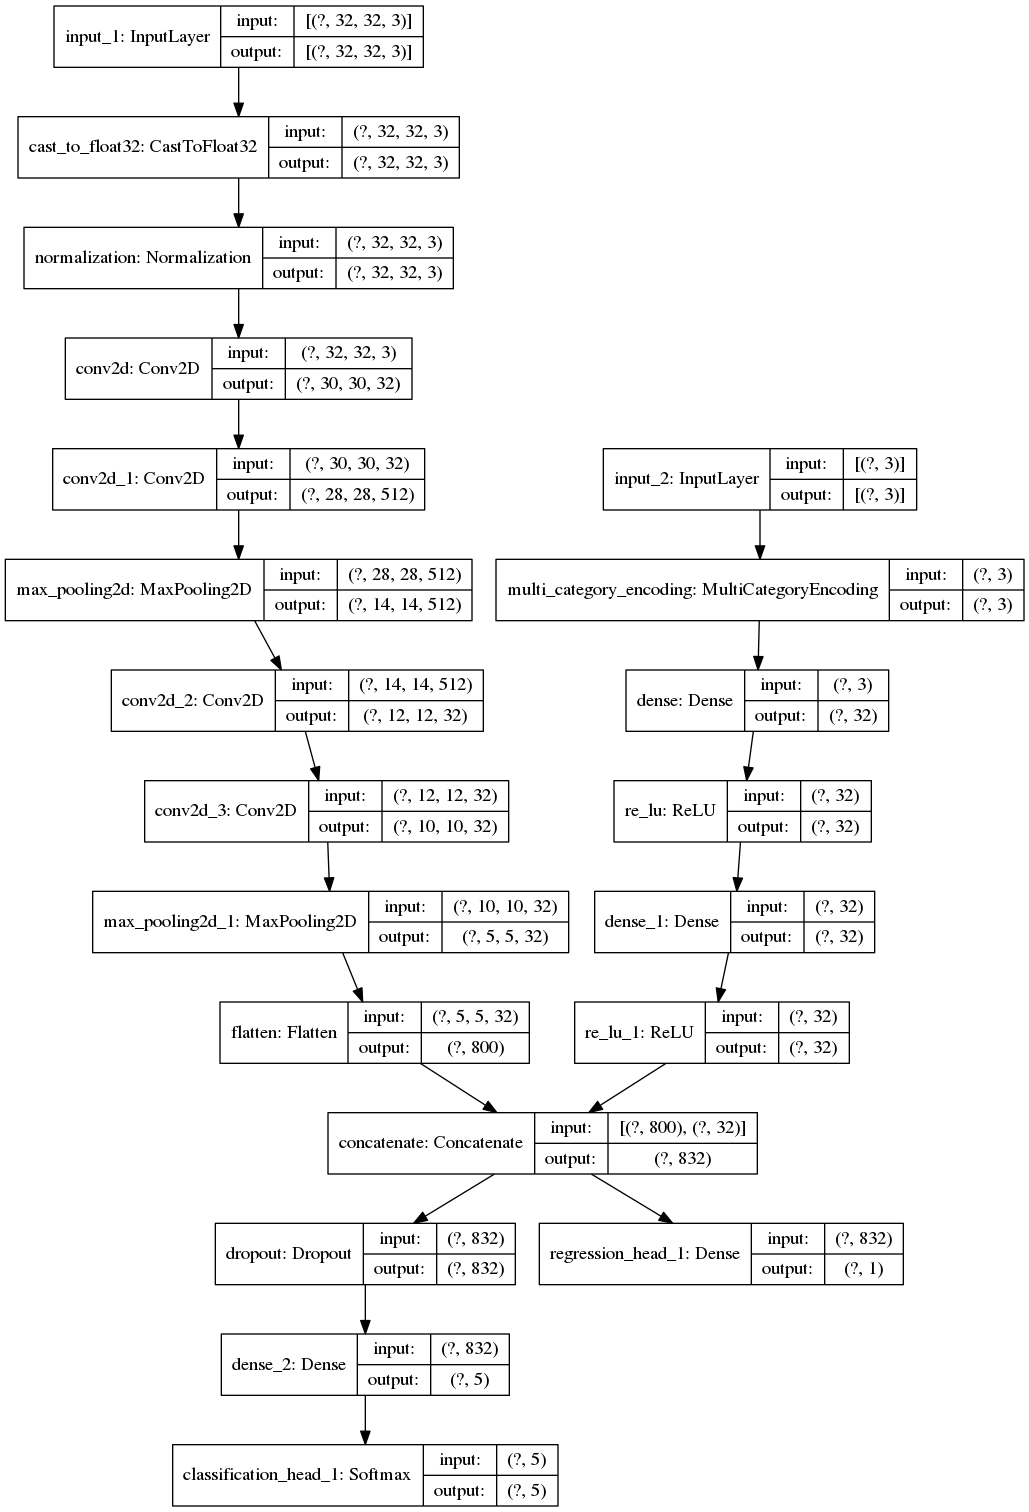

In [10]:
tf.keras.utils.plot_model(best_model, show_shapes=True, expand_nested=True) # rankdir='LR'

### Evaluate the best model on the test data.

In [45]:

total_loss, clf_loss, reg_loss, clf_acc, reg_mse = auto_model.evaluate(
                                    [image_test, structured_test],
                                    [clf_target_test, reg_target_test],
                                    )
print('\nTotal testing loss: ', total_loss)
print('Classification testing cross-entropy loss: ', clf_loss)
print('Regression testing MSE loss: ', reg_loss)
print('Classification testing accuracy: ', clf_acc)
print('Regression testing MSE: ', reg_mse)


1/1 [==============================] - 0s 2ms/step - loss: 1.7260 - classification_head_1_loss: 1.6186 - regression_head_1_loss: 0.1074 - classification_head_1_accuracy: 0.2000 - regression_head_1_mean_squared_error: 0.1074

Total testing loss:  1.7259817123413086
Classification testing cross-entropy loss:  1.6186262369155884
Regression testing MSE loss:  0.10735546052455902
Classification testing accuracy:  0.20000000298023224
Regression testing MSE:  0.10735546052455902


## Reference
[ImageClassifier](/image_classifier),
[AutoModel](/auto_model/#automodel-class),
[ImageBlock](/block/#imageblock-class),
[Normalization](/preprocessor/#normalization-class),
[ImageAugmentation](/preprocessor/#image-augmentation-class),
[ResNetBlock](/block/#resnetblock-class),
[ImageInput](/node/#imageinput-class),
[ClassificationHead](/head/#classificationhead-class).